In [1]:
import sys
print(sys.path)
sys.path[3] = '/home/ax/data/programs/mitsuba2/debug/dist/python'
print(sys.path)

['/home/ax/data/DeepExplain/experiments/mitsuba', '/home/ax/data/DeepExplain/experiments/mitsuba', '/home/ax/data/programs/mitsuba2/build/dist/python', '/home/ax/miniconda3/lib/python37.zip', '/home/ax/miniconda3/lib/python3.7', '/home/ax/miniconda3/lib/python3.7/lib-dynload', '', '/home/ax/miniconda3/lib/python3.7/site-packages', '/home/ax/data/programs/pytorch-openpose', '/home/ax/miniconda3/lib/python3.7/site-packages/IPython/extensions', '/home/ax/.ipython']
['/home/ax/data/DeepExplain/experiments/mitsuba', '/home/ax/data/DeepExplain/experiments/mitsuba', '/home/ax/data/programs/mitsuba2/build/dist/python', '/home/ax/data/programs/mitsuba2/debug/dist/python', '/home/ax/miniconda3/lib/python3.7', '/home/ax/miniconda3/lib/python3.7/lib-dynload', '', '/home/ax/miniconda3/lib/python3.7/site-packages', '/home/ax/data/programs/pytorch-openpose', '/home/ax/miniconda3/lib/python3.7/site-packages/IPython/extensions', '/home/ax/.ipython']


In [2]:
%load_ext autoreload
%autoreload 2

import time
import torch
import kornia
import cv2
import copy
from matplotlib import pyplot as plt
from matplotlib import gridspec

import numpy as np
from tqdm import tqdm
import wandb
from torch_openpose.body import Body
from torch_openpose import util



import enoki as ek
import mitsuba
mitsuba.set_variant('gpu_autodiff_rgb')


from mitsuba.python.autodiff import render, render_torch, write_bitmap
from mitsuba.python.util import traverse
from mitsuba.core.xml import load_file
from mitsuba.core import Thread, Vector3f, LogLevel

ek.cuda_set_log_level(4)

In [3]:
def wandb_init(name):
    run = wandb.init(
        project = "mts_texture_test", 
        reinit = True,
        name = name,
        config={
            "steps": 100,
            "learning_rate": 0.2,
            "optimizer": "Adam",
            "noise_width": 200,
            "noise_height": 400,
        }
    )
    
    return run 

def get_image_as_mitsuba_tensor(np_image, device):
    img_flatten = np_image.flatten() / 255
    return torch.from_numpy(img_flatten).to(device)



In [ ]:
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
ORIG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
origal_file_name = 'pose_scene/uv.jpg'
origal_texture = cv2.imread(origal_file_name)[..., (2,1,0)]
diff_parameter = 'rect.bsdf.reflectance.data'

SPP = 24
noise_resolution  = np.array([200, 400])

device = torch.device("cuda:0")


thread = Thread.thread()
thread.file_resolver().append('pose_scene')
logger = thread.logger()
logger.set_log_level(LogLevel.Warn)

scene = load_file('pose_scene/scene_image_texture.xml')
params = traverse(scene)


params.keep([diff_parameter])
params[diff_parameter] = origal_texture.flatten() / 255
params.update()
params_torch = params.torch()
params_torch[diff_parameter] = get_image_as_mitsuba_tensor(origal_texture, device)


# Render a reference image (no derivatives used yet)
rendering_torch_ref = render_torch(scene, params=params, unbiased=True, spp=SPP, **params_torch)

canvas = rendering_torch_ref.cpu().detach().numpy() 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(canvas)
ax.axis('off')

[0.30588235 0.42352941 0.65882353 0.30588235 0.42352941 0.65882353
 0.30196078 0.41960784 0.65490196 0.30196078]
[0.07618543 0.14995983 0.39157254 0.07618543 0.14995983 0.39157254
 0.07421362 0.14702731 0.38642946 0.07421362]
118.25851593500907


(-0.5, 199.5, 399.5, -0.5)

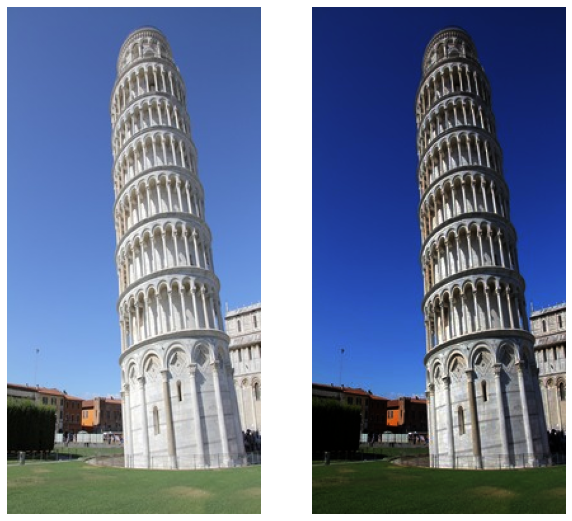

In [35]:
def get_image_as_mitsuba_tensor(np_image, orig):
    img_flatten = np_image.flatten() / 255
    print(img_flatten[:10])
    
    orig_np = orig.detach().cpu().numpy()
    print(orig_np[:10])
    print(np.linalg.norm(orig_np - img_flatten))
    
    
    return img_flatten, orig_np

diff_parameter = 'rect.bsdf.reflectance.data'
params.keep([diff_parameter])
params.update()
# Which parameters should be exposed to the PyTorch optimizer?
params_torch = params.torch()

img_flatten, orig_np = get_image_as_mitsuba_tensor(origal_texture, params_torch[diff_parameter])

canvas = img_flatten.reshape(noise_resolution[1], noise_resolution[0], -1)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(canvas)
ax.axis('off')

canvas = orig_np.reshape(noise_resolution[1], noise_resolution[0], -1)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(canvas)
ax.axis('off')

In [74]:
run = wandb_init(origal_file_name)
noise_resolution  = np.array([200, 400])


diff_parameter = 'rect.bsdf.reflectance.data'
params.keep([diff_parameter])
params[diff_parameter] = [0] * len(params[diff_parameter])
params.update()
# Which parameters should be exposed to the PyTorch optimizer?
params_torch = params.torch()
REGULARIZATION = torch.tensor(1e-7, device=device)

# set up optimizer
opt = torch.optim.Adam(params_torch.values(), lr=run.config.learning_rate)
objective = torch.nn.MSELoss()


for step in tqdm(range(run.config.steps)):
    if step % 50 ==  0:
        write_bitmap('output/image_texture_%03i.png' % step, params_torch[diff_parameter], noise_resolution)
    opt.zero_grad()

    # render image
    # maybe add malloc_trim=True if memory issues
    cur_rednering_torch = render_torch(scene, params=params, unbiased=True, spp=SPP, **params_torch)
    
    ob_val_heat = objective(rendering_torch_ref, cur_rednering_torch)
    y = params_torch[diff_parameter].view(noise_resolution[1], noise_resolution[0], 3)
    y = y.permute((2, 0, 1))
    ob_val = ob_val_heat + REGULARIZATION * (
        torch.sum(torch.abs(y[:, :, :-1] - y[:, :, 1:])) + 
        torch.sum(torch.abs(y[:, :-1, :] - y[:, 1:, :]))
    )
    
    # calc gradient
    ob_val.backward()
    
    # take a step in gradient direction
    opt.step()
    
    # log the loss
    wandb.log({'loss': ob_val.item()}, step=step)


100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Original')

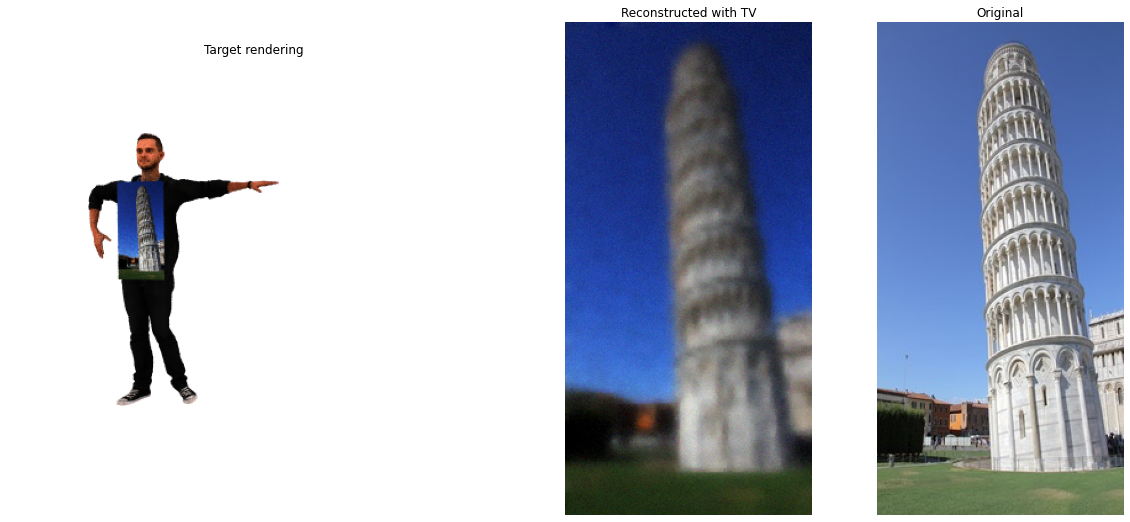

In [75]:
canvas = params_torch[diff_parameter].detach().cpu().numpy()
canvas = canvas.reshape(noise_resolution[1], noise_resolution[0], -1)


rendering_canvas = rendering_torch_BGR.cpu().detach().numpy() 

fig = plt.figure(figsize=(20, 60))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])

ax = plt.subplot(gs[0])
ax.imshow(rendering_canvas[:, :, [2, 1, 0]])
ax.axis('off')
ax.set_title('Target rendering')

ax = plt.subplot(gs[1])
ax.imshow(canvas)
ax.axis('off')
ax.set_title('Reconstructed with TV')

ax = plt.subplot(gs[2])
ax.imshow(origal_texture[:, :, [2, 1, 0]])
ax.axis('off')
ax.set_title('Original')